In [165]:
# General libraries:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

# Personal libraries:
# from robin_helperfunctions import round_to_hour
# from robinhoodstrategy import cryptoStrategy, BackcastStrategy, Trade

# Deep learning libraries:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, MaxPooling1D, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop

In [139]:
# Load historical data from file:
df = pd.read_csv('eth_historical_4hrs.csv')

# Convert timezones and reformat:
df['time_period_start'] = pd.to_datetime(df['time_period_start']).dt.tz_convert('US/Central').dt.strftime('%m-%d-%Y %H:%M')

# Pull just the value fields:
df = df[['price_close', 'price_open', 'price_high', 'price_low', 'volume_traded', 'trades_count']]

df.head()

,price_close,price_open,price_high,price_low,volume_traded,trades_count
0,11.8895,11.87000,11.90000,11.85972,1076.171006,48
1,12.0000,11.89000,12.00000,11.89000,6184.443260,182
2,12.0300,12.00000,12.03000,11.93356,3391.487460,120
3,12.2000,12.02591,12.20000,12.00000,1590.240506,53
4,12.4310,12.20000,12.54799,12.20000,4801.330298,164


In [140]:
def entry_flag(df, lookforward_num=3, pct_gain=0.03):
    
    '''If there will be over a x% gain in the next x periods, flag as a 1. Else 0.'''
    
    df['pctchange'] = df[['price_close']].pct_change(lookforward_num)
    
    entry_flags = []
    for i in range(len(df) - lookforward_num):
        if df.iloc[i+lookforward_num]['pctchange'] >= pct_gain:
            entry_flags.append(1)
        else:
            entry_flags.append(0)
    # Add in buffer None's
    for i in range(lookforward_num):
        entry_flags.append(None)
    return entry_flags

In [141]:
df['entry_flag'] = entry_flag(df)
df['entry_flag'].value_counts()

0.0    7117
1.0    1293
Name: entry_flag, dtype: int64

In [142]:
def create_sequence(df, n_input): 
    
    data = np.array(df)
    
    X = list()
    start = n_input
    for _ in range(len(data)):
        # define the end of the input sequence
        end = start + n_input
        # ensure we have enough data for this instance 
        if end <= len(data) - n_input:
            X.append(data[start:end, :])
        # move along one time step
        start += 1
    return np.array(X)

def create_targets(df, n_input):
    return np.array(df['entry_flag'][(n_input-1):-n_input*2].values).reshape(-1,1)

In [152]:
seq_len = 42
df_features = df.drop(columns=['pctchange', 'entry_flag'])
X = create_sequence(df_features, seq_len)
y = create_targets(df, seq_len)

In [153]:
def normalized_df(X):
    return np.array([x/x[0]-1 for x in X])

def trainTest_split(X, training_size=0.8):
    return X[:int(training_size*len(X))], X[int(training_size*len(X)):]

In [154]:
X_norm = normalized_df(X)
X_train, X_test = trainTest_split(X_norm)
y_train, y_test = trainTest_split(y)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6630, 42, 6) (6630, 1)
(1658, 42, 6) (1658, 1)


In [155]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

In [156]:
# define the CNN model
model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=(n_timesteps,n_features))) 
model.add(Conv1D(32, 3, activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='sigmoid')) 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

0.9559710621833801


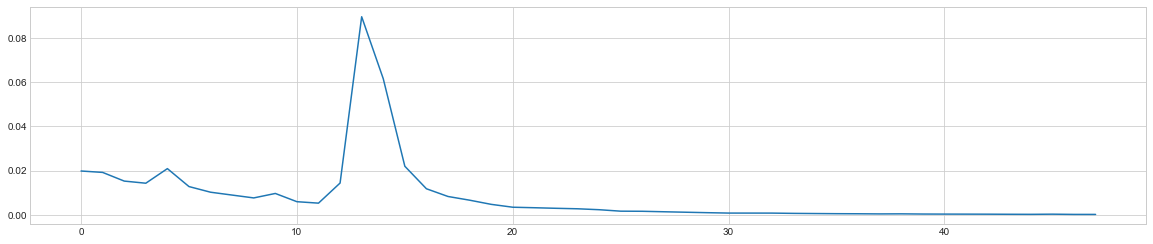

In [160]:
verbose, epochs, batch_size = 0, 48, 64
results = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
# evaluate model
_, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
plt.figure(figsize=(20,4))
print(accuracy)
plt.plot(results.history['loss'])
plt.show()

In [161]:
predictions = model.predict(X_test)
predictions_round = [1 if x > 0.5 else 0 for x in predictions]
pd.Series(predictions_round).value_counts()

0    1450
1     208
dtype: int64

In [170]:
df_plot = df[-len(X_test):].reset_index()
df_plot['predictions'] = predictions_round
print(classification_report(df_plot['entry_flag'][10:-10].values, df_plot['predictions'][10:-10].values))

              precision    recall  f1-score   support

         0.0       0.88      0.88      0.88      1424
         1.0       0.18      0.18      0.18       214

    accuracy                           0.79      1638
   macro avg       0.53      0.53      0.53      1638
weighted avg       0.79      0.79      0.79      1638



In [171]:
df_plot

,index,price_close,price_open,price_high,price_low,volume_traded,trades_count,pctchange,entry_flag,predictions
0,6755,146.52,147.77,147.80,145.94,2367.550378,547,-0.009933,0.0,0
1,6756,147.32,146.51,147.78,146.34,1838.469669,388,-0.000543,0.0,0
2,6757,148.50,147.28,149.80,146.96,6558.625819,831,0.004600,0.0,0
3,6758,148.90,148.54,149.17,148.12,1662.453247,548,0.016244,0.0,0
4,6759,148.71,148.97,149.72,148.53,3203.790378,415,0.009435,0.0,0
...,...,...,...,...,...,...,...,...,...,...
1653,8408,352.51,353.48,359.90,348.35,18060.435159,4312,-0.005417,0.0,1
1654,8409,348.30,352.50,358.50,344.10,11786.213649,2541,0.010561,0.0,0
1655,8410,343.44,347.95,351.55,337.26,14951.134623,2988,-0.027495,NaN,0
1656,8411,335.77,343.46,349.46,332.31,18696.797778,3650,-0.047488,NaN,0


In [176]:
fig = px.line(df_plot, x=df_plot.index, y="predictions")
fig.show()

# for i in range(len(df_plot)):
#     if df_plot.iloc[i, 8] == 1:
#         plt.annotate('.', (i, df_plot.iloc[i]['price_close']), fontsize=4)
# # plt.tight_layout()
# # plt.savefig('result_plot.png')

In [164]:
model.save('4h_6period_cnn.h5')

In [40]:
# df_plot[df_plot['entry_flag']==1]

,price_close,price_open,price_high,price_low,volume_traded,trades_count,pctchange,entry_flag,predictions
6823,122.73,127.75,128.39,122.32,18837.707748,2454,-0.067685,1.0,0
6824,121.75,122.64,123.10,119.62,24784.506558,2651,-0.080924,1.0,0
6825,123.73,121.75,125.44,121.32,13743.108024,1256,-0.061087,1.0,0
6826,121.69,123.72,124.38,120.74,24605.075843,7289,-0.069648,1.0,0
6848,127.02,127.03,127.53,127.00,2663.465161,289,-0.009668,1.0,0
...,...,...,...,...,...,...,...,...,...
8372,433.98,436.81,438.51,428.66,13476.368398,3166,0.012269,1.0,0
8373,443.88,434.00,444.41,428.68,14025.545545,3049,0.043834,1.0,0
8401,323.29,357.08,359.43,311.04,99870.049276,14288,-0.176289,1.0,0
8402,335.38,323.43,337.55,314.83,36026.491585,5561,-0.130735,1.0,0


___